In [12]:
import numpy as np
import matplotlib.pyplot as plt
from Network import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import matplotlib as mpl
import os  # Import the os module to handle file directory operations

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Parameters
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
Coding_range = lambda_1 * lambda_2 * lambda_3
# connection range
a_p = 0.3
a_g = a_p/Lambda*2*np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p/50
# divisive normalization
k_p = 20.
k_g = Lambda/2/np.pi * k_p
# time constants
tau_p = 1.
tau_g = 2*np.pi * tau_p/Lambda
# cell number
num_p = int(1280)*2
rho_p = num_p/Coding_range
rho_g = rho_p
num_g = int(rho_g*2*np.pi) # 为了让两个网络的rho相等
print(num_g)

268


In [14]:
# 生成Ip, Ig
sigma_phi = 0.01
sigma_g = 0.05
sigma_p = 0.05
# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = bm.where(dis>bm.pi, dis-2*bm.pi, dis)
    dis = bm.where(dis<-bm.pi, dis+2*bm.pi, dis)
    return dis
# feature space
x = np.linspace(0, Coding_range, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
num_module = len(Lambda)
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
psi = phi_truth + sigma_phi * np.random.randn(num_module)
psi = phi_truth 
Ig = np.zeros((num_module, num_g))
for i in range(num_module):
    dis_theta = circ_dis(theta, psi[i])
    Ig[i, :] = np.exp(-dis_theta**2 / (4 * a_g[i] ** 2)) + sigma_g * np.random.randn(num_g)
x = np.linspace(0,Coding_range,num_p,endpoint=False)
dis_x = x-z_truth
Ip = np.exp(-dis_x**2 / (4 * a_p**2)) + sigma_p * np.random.randn(num_p)




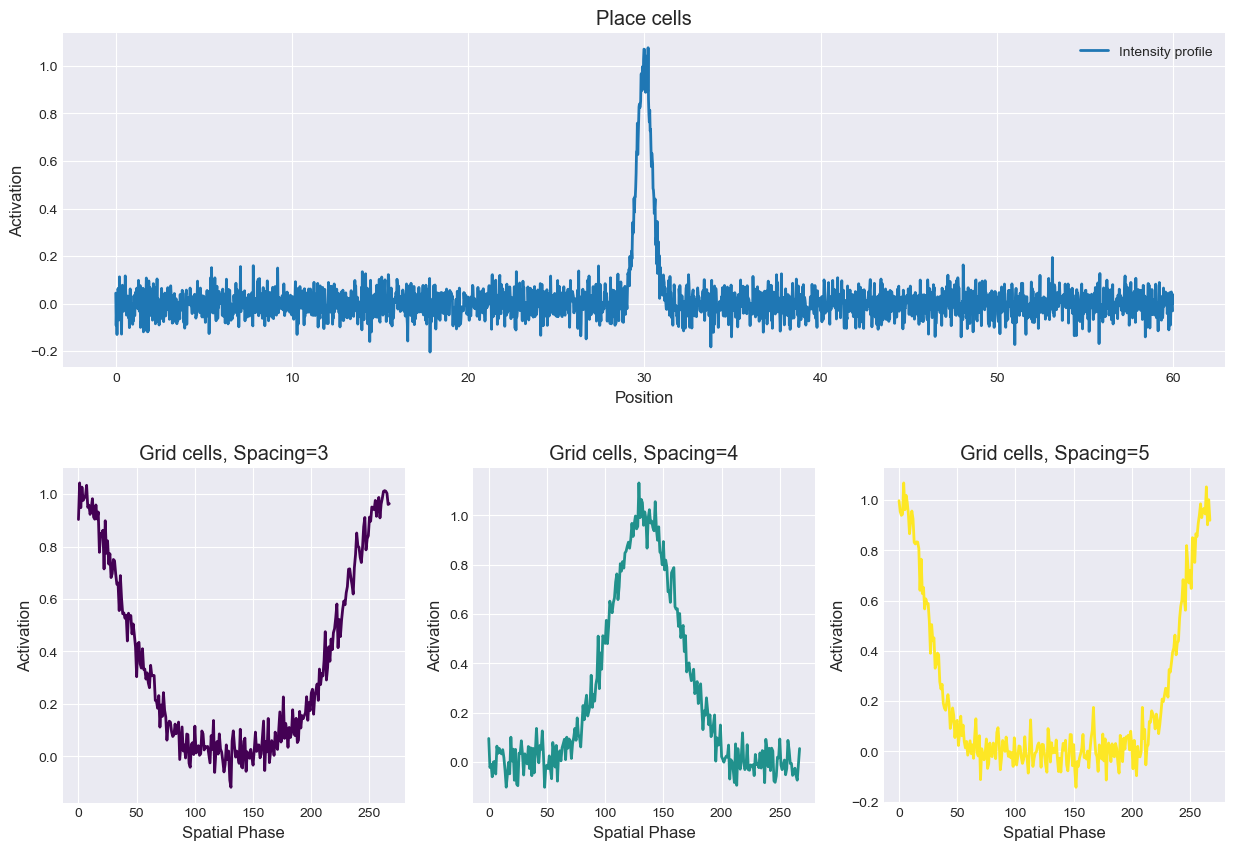

In [15]:
def plot_data(Ip,Ig):
    # 设置美化风格
    plt.style.use('seaborn-darkgrid')
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['axes.labelsize'] = 'large'
    mpl.rcParams['axes.titlesize'] = 'x-large'

    # 前面的数据生成部分代码保持不变

    # 设置图形和子图网格
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], hspace=0.3)

    # 第一行，一个子图占据所有三列
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(x, Ip.flatten(), label='Intensity profile')
    ax1.set_title('Place cells')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Activation')
    ax1.legend()

    # 第二行，三个子图分别占据一列
    colors = plt.cm.viridis(np.linspace(0, 1, num_module))  # 使用Colormap
    for i in range(num_module):
        ax = plt.subplot(gs[1, i])
        ax.plot(Ig[i, :], color=colors[i])
        ax.set_title(f'Grid cells, Spacing={Lambda[i]}')
        ax.set_xlabel('Spatial Phase')
        ax.set_ylabel('Activation')
plot_data(Ip,Ig)


In [16]:
### 实例化网络模型
### Place cells
P_CANN = Place_net(z_min=0, z_max=Coding_range, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
### Grid cells
G_CANNs = bm.NodeList()
for i in range(num_module):
    G_CANNs.append(Grid_net(z_min=0, z_max=Coding_range, num = num_g, num_hpc=num_p, L = Lambda[i], a_g = a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))
### Coupled Network
Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=num_module)


In [17]:
# run net functions

def initial_net(alpha_p, alpha_g, Ip, Ig): 
    Coupled_model.initial(alpha_p, alpha_g, Ip, Ig)
    u_HPC = Coupled_model.HPC_model.u
    u_grid = bm.zeros([num_module,num_g])
    for i in range(num_module):
        u_grid[i] = Coupled_model.MEC_model_list[i].u
    I_mec = Coupled_model.I_mec
    return u_HPC, u_grid, I_mec

def run_net(i, alpha_p, alpha_g, Ip, Ig): 
    Coupled_model.step_run(i, alpha_p, alpha_g, Ip, Ig)
    u_HPC = Coupled_model.HPC_model.u
    u_grid = bm.zeros([num_module,num_g])
    for i in range(num_module):
        u_grid[i] = Coupled_model.MEC_model_list[i].u
    I_mec = Coupled_model.I_mec
    phi_decode = Coupled_model.phase
    z_decode = Coupled_model.HPC_model.center
    energy =  Coupled_model.energy
    return u_HPC, u_grid, I_mec, z_decode, phi_decode, energy


  0%|          | 0/8000 [00:00<?, ?it/s]

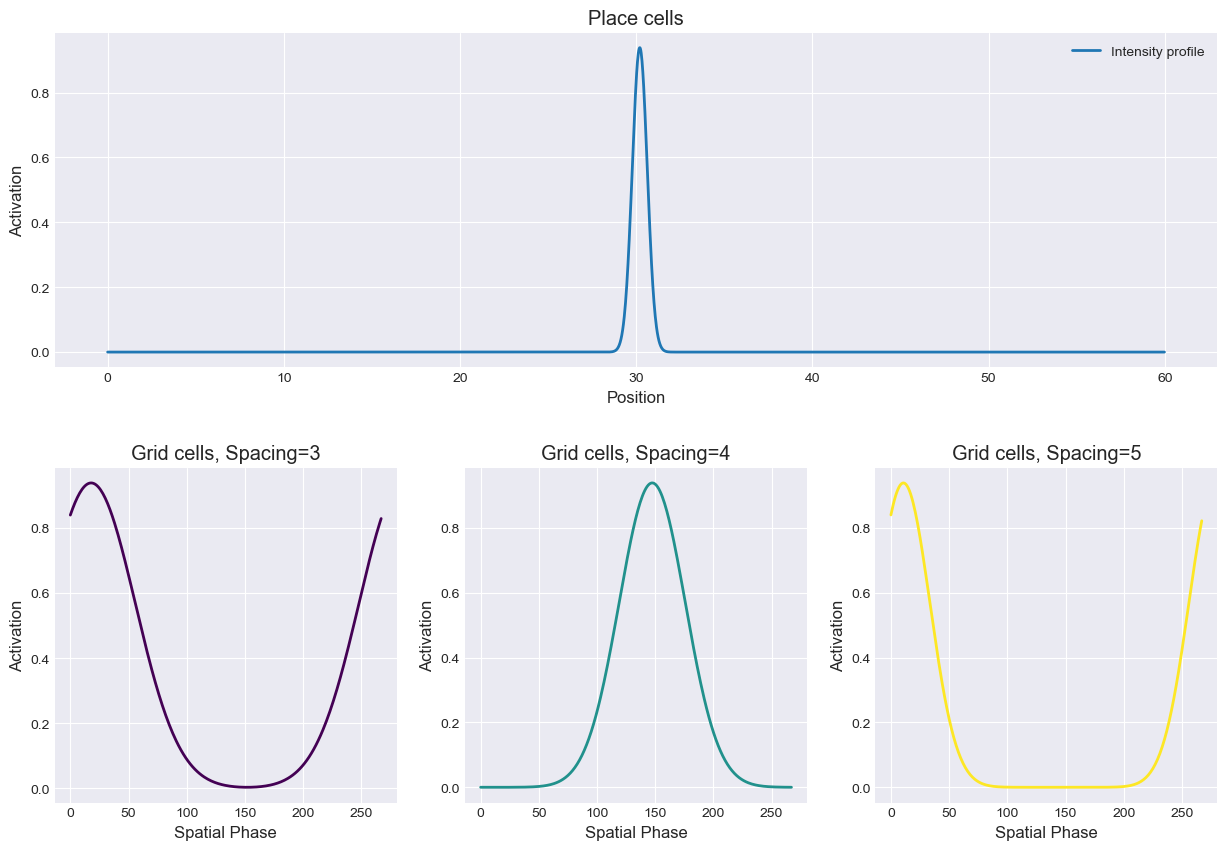

In [18]:
# Initialize the network
T = 8000
indices = np.arange(T)
z0 = 30.2
phi_0 = np.mod(z0 / Lambda, 1) * 2 * np.pi
fg = np.zeros((num_module, num_g))
for i in range(num_module):
    dis_theta = circ_dis(theta, phi_0[i])
    fg[i, :] = np.exp(-dis_theta**2 / (4 * a_g[i] ** 2))
x = np.linspace(0,Coding_range,num_p,endpoint=False)
dis_x = x-z0
fp = np.exp(-dis_x**2 / (4 * a_p**2))
I_place = 1*np.repeat(fp[np.newaxis, :], T, axis=0)
I_grid = 1*np.repeat(fg[np.newaxis, :, :], T, axis=0)
alpha_p = np.zeros(T,) + 1
alpha_g = np.zeros(T,) + 1
I_place[int(T/2):,:] = 0
I_grid[int(T/2):,:,:] = 0
u_HPC_init, u_grid_init, I_mec_init = bm.for_loop(initial_net, (alpha_p, alpha_g, I_place, I_grid), progress_bar=True)



plot_data(u_HPC_init[-1,:],u_grid_init[-1,:,:])

In [19]:

# input_strength
A_p = 0.0
A_g = 0.1

### 
T = 5000
indices = np.arange(T)
alpha_p = np.zeros(T,) + A_p
alpha_g = np.zeros(T,) + A_g


I_place = np.repeat(Ip[np.newaxis, :], T, axis=0)
I_grid = np.repeat(Ig[np.newaxis, :, :], T, axis=0)
u_HPC, u_grid, I_mec, z_decode, phi_decode, energy = bm.for_loop(run_net, (indices, alpha_p, alpha_g, I_place, I_grid), progress_bar=True)


  0%|          | 0/5000 [00:00<?, ?it/s]

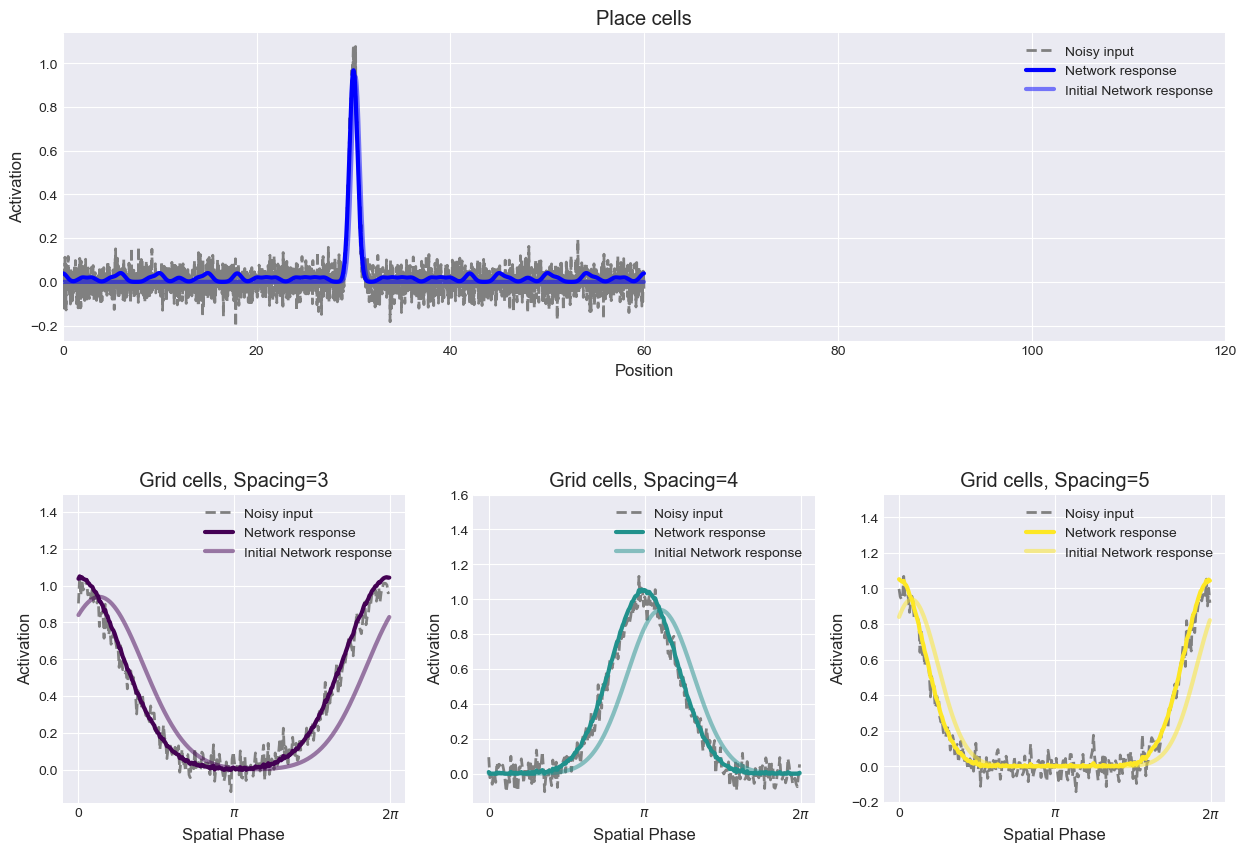

In [20]:
import os  # Import the os module to handle file directory operations

def plot_data(Ip, Ig, U_p, U_g, U_p_init, U_g_init):
    # Set plot style
    plt.style.use('seaborn-darkgrid')
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['axes.labelsize'] = 'large'
    mpl.rcParams['axes.titlesize'] = 'x-large'
    mpl.rcParams['legend.fontsize'] = 'medium'  # Adjust legend font size

    # Set up the figure and subplots
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], hspace=0.5)  # Increased vertical space

    # First row, one subplot across all three columns
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(x, Ip.flatten(), label='Noisy input', color='grey', linestyle='dashed')  # Noisy input as dashed line
    ax1.plot(x, U_p.flatten(), label='Network response', color='blue', linewidth=3, linestyle='-')  # Solid line for network response
    ax1.plot(x, U_p_init.flatten(), label='Initial Network response', color='blue', linewidth=3, linestyle='-', alpha=0.5)  # Initial response as solid line with transparency
    ax1.set_xlim(0,120)
    ax1.set_title('Place cells')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Activation')
    ax1.legend()

    # Second row, three subplots, one for each module
    colors = plt.cm.viridis(np.linspace(0, 1, num_module))  # Color map for responses
    for i in range(num_module):
        ax = plt.subplot(gs[1, i])
        ax.plot(theta, Ig[i, :], color='grey', linestyle='dashed', label='Noisy input')  # Dashed line for noisy input
        ax.plot(theta, U_g[i, :], color=colors[i], linewidth=3, linestyle='-', label='Network response')  # Solid line for network response
        ax.plot(theta, U_g_init[i, :], color=colors[i], linewidth=3, linestyle='-', alpha=0.5, label='Initial Network response')  # Initial response as solid line with transparency
        ax.set_title(f'Grid cells, Spacing={Lambda[i]}')
        ax.set_xlabel('Spatial Phase')
        ax.set_ylabel('Activation')
        ax.set_xticks([0, np.pi, 2 * np.pi])  # Set x-axis ticks at 0, pi, and 2pi
        ax.set_xticklabels(['0', r'$\pi$', r'$2\pi$'])  # Use LaTeX formatted labels
        ax.legend()

        # Adjust y-axis for each subplot to prevent legend overlap
        y_lim = ax.get_ylim()
        ax.set_ylim(y_lim[0], y_lim[1] + 0.3 * (y_lim[1] - y_lim[0]))  # Adds 30% space at the top for the legend


    # Check if the directory exists and create it if it doesn't
    directory = r'figure_decoration'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure
    plt.savefig(os.path.join(directory, "Network_response.png"))




U_p = u_HPC[-1,:]
U_g = u_grid[-1,:,:]
U_p_init = u_HPC_init[-1,:]
U_g_init = u_grid_init[-1,:,:]
plot_data(Ip, Ig, U_p, U_g, U_p_init, U_g_init)

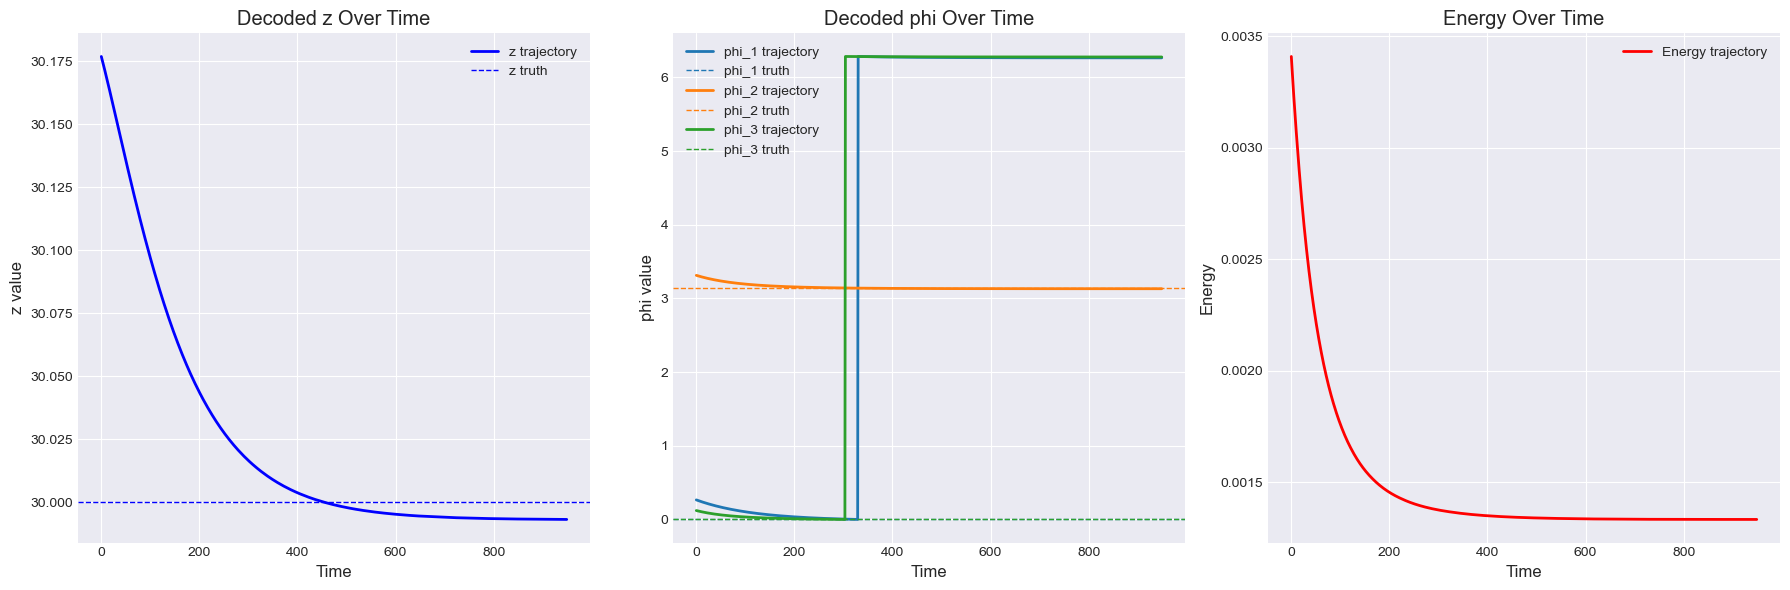

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

def plot_decoding_trajectories(z_decode, phi_decode, energy, z_truth, phi_truth):
    # Set plot style
    plt.style.use('seaborn-darkgrid')
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['axes.labelsize'] = 'large'
    mpl.rcParams['axes.titlesize'] = 'x-large'
    mpl.rcParams['legend.fontsize'] = 'medium'  # Adjust legend font size

    # Create figure and subplots (now 1 row and 3 columns)
    fig = plt.figure(figsize=(18, 6))  # Adjusted figure size for better aspect ratio
    gs = gridspec.GridSpec(1, 3)  # One row, three columns

    # Time array (assuming T is the length of the input data)
    T = z_decode.shape[0]
    time = np.arange(T)

    # Plot z_decode
    ax1 = plt.subplot(gs[0, 0])  # First column
    z_line, = ax1.plot(time, z_decode, label='z trajectory', color='blue')
    ax1.axhline(y=z_truth, color=z_line.get_color(), linestyle='--', linewidth=1, label='z truth')  # True z value as horizontal line
    ax1.set_title('Decoded z Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('z value')
    ax1.legend()

    # Plot phi_decode for each dimension
    ax2 = plt.subplot(gs[0, 1])  # Second column
    for i in range(phi_decode.shape[1]):  # Assuming phi_decode is T*3
        phi_line, = ax2.plot(time, phi_decode[:, i], label=f'phi_{i+1} trajectory')
        ax2.axhline(y=phi_truth[i], color=phi_line.get_color(), linestyle='--', linewidth=1, label=f'phi_{i+1} truth')  # True phi values as horizontal lines
    ax2.set_title('Decoded phi Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('phi value')
    ax2.legend()

    # Plot energy
    ax3 = plt.subplot(gs[0, 2])  # Third column
    energy_line, = ax3.plot(time, energy, label='Energy trajectory', color='red')
    ax3.set_title('Energy Over Time')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Energy')
    ax3.legend()

    # Adjust layout
    plt.tight_layout()

    # Check if the directory exists and create it if it doesn't
    directory = r'figure_decoration'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure
    plt.savefig(os.path.join(directory, "Decoding_trajectorys.png"))

# Call the function to plot the data
start = 50
end = 1000
plot_decoding_trajectories(z_decode[start:end], phi_decode[start:end]+np.pi, energy[start:end], z_truth, phi_truth)


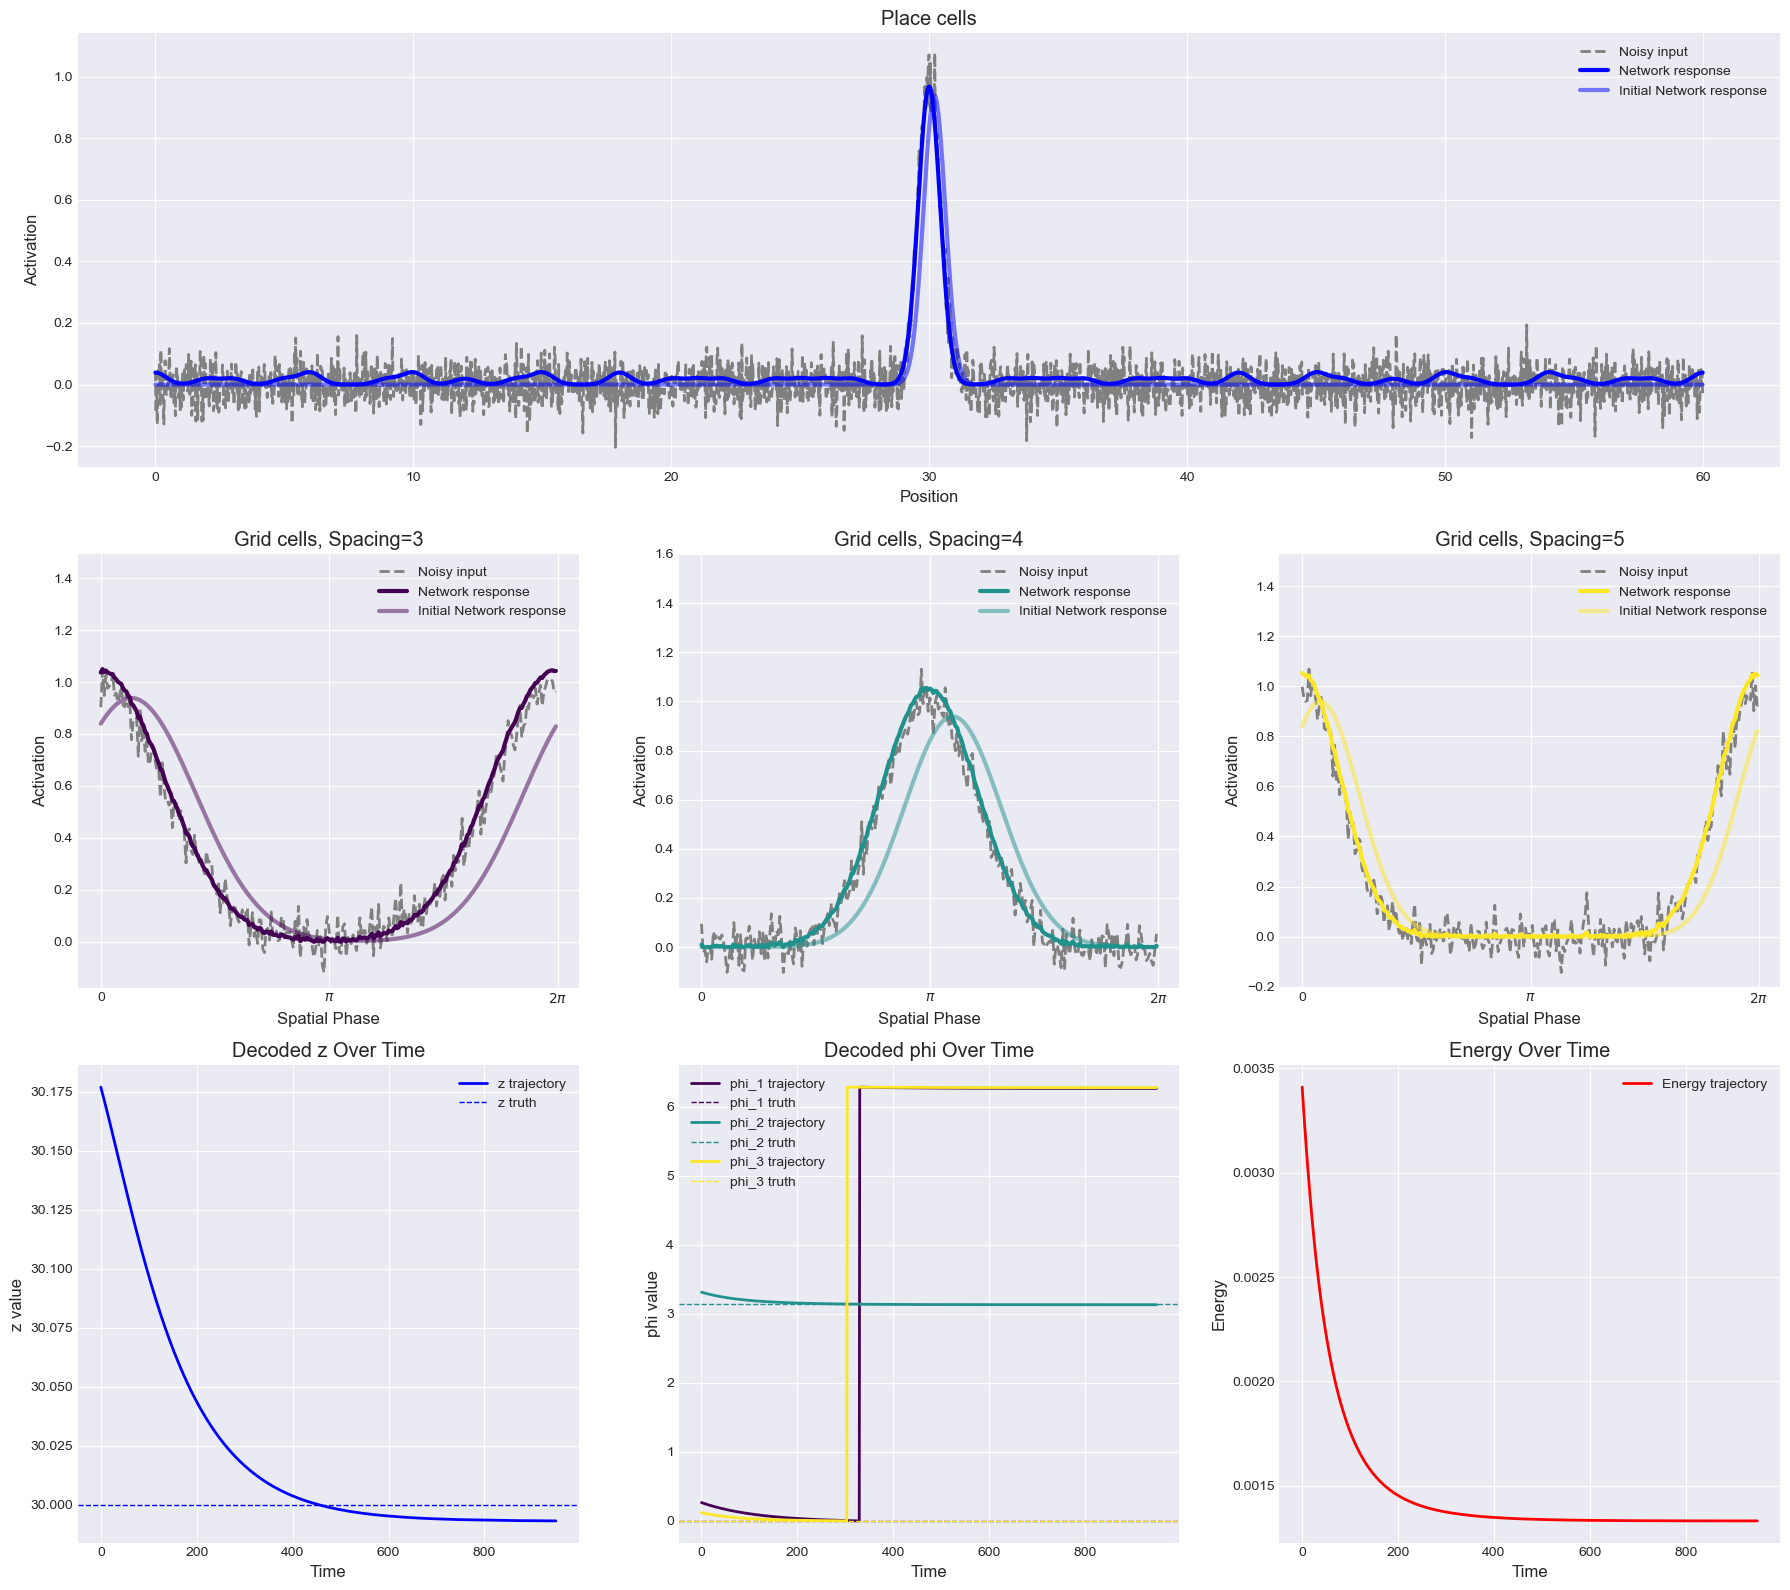

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import os

def plot_combined_figures(Ip, Ig, U_p, U_g, U_p_init, U_g_init, z_decode, phi_decode, energy, z_truth, phi_truth):
    # Define colors for each module using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(Ig)))  # Assuming len(Ig) gives the number of modules
    # Time array (assuming T is the length of the input data)
    T = z_decode.shape[0]
    time = np.arange(T)
    # Set plot style
    plt.style.use('seaborn-darkgrid')
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['axes.labelsize'] = 'large'
    mpl.rcParams['axes.titlesize'] = 'x-large'
    mpl.rcParams['legend.fontsize'] = 'medium'  # Adjust legend font size

    # Create figure and large gridspec
    fig = plt.figure(figsize=(18, 16))  # Larger figure to accommodate both sets of plots
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])  # Specify height ratios, giving more space to the first row if needed

    # Upper grid for network response plots
    gs_upper = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], hspace=0.2)

    # Plot Network responses
    ax1 = plt.subplot(gs_upper[0, :])
    ax1.plot(x, Ip.flatten(), label='Noisy input', color='grey', linestyle='dashed')
    ax1.plot(x, U_p.flatten(), label='Network response', color='blue', linewidth=3, linestyle='-')
    ax1.plot(x, U_p_init.flatten(), label='Initial Network response', color='blue', linewidth=3, linestyle='-', alpha=0.5)
    ax1.set_title('Place cells')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Activation')
    # ax1.set_xlim(0,120)
    ax1.legend()

    for i in range(len(Ig)):
        ax = plt.subplot(gs_upper[1, i])
        ax.plot(theta, Ig[i, :], color='grey', linestyle='dashed', label='Noisy input')
        ax.plot(theta, U_g[i, :], color=colors[i], linewidth=3, linestyle='-', label='Network response')
        ax.plot(theta, U_g_init[i, :], color=colors[i], linewidth=3, linestyle='-', alpha=0.5, label='Initial Network response')
        ax.set_title(f'Grid cells, Spacing={Lambda[i]}')
        ax.set_xlabel('Spatial Phase')
        ax.set_ylabel('Activation')
        ax.set_xticks([0, np.pi, 2 * np.pi])
        ax.set_xticklabels(['0', r'$\pi$', r'$2\pi$'])
        ax.legend()
        # Adjust y-axis for each subplot to prevent legend overlap
        y_lim = ax.get_ylim()
        ax.set_ylim(y_lim[0], y_lim[1] + 0.3 * (y_lim[1] - y_lim[0]))  # Adds 30% space at the top for the legend


    # Lower grid for decoding trajectory plots
    gs_lower = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1])

    # Plot Decoding trajectories
    ax3 = plt.subplot(gs_lower[0, 0])
    ax3.plot(time, z_decode, label='z trajectory', color='blue')
    ax3.axhline(y=z_truth, color='blue', linestyle='--', linewidth=1, label='z truth')
    ax3.set_title('Decoded z Over Time')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('z value')
    ax3.legend()

    ax4 = plt.subplot(gs_lower[0, 1])
    for i in range(phi_decode.shape[1]):
        phi_line, = ax4.plot(time, phi_decode[:, i], color=colors[i], label=f'phi_{i+1} trajectory')
        ax4.axhline(y=phi_truth[i], color=colors[i], linestyle='--', linewidth=1, label=f'phi_{i+1} truth')
    ax4.set_title('Decoded phi Over Time')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('phi value')
    ax4.legend()

    ax5 = plt.subplot(gs_lower[0, 2])
    ax5.plot(time, energy, label='Energy trajectory', color='red')
    ax5.set_title('Energy Over Time')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Energy')
    ax5.legend()

    # Adjust layout
    plt.tight_layout()

    # Check if the directory exists and create it if it doesn't
    directory = r'figure_decoration'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure
    plt.savefig(os.path.join(directory, "Combined_Network_and_Decoding_Trajectories.png"))

# Ensure all necessary variables (x, theta, num_module, colors, etc.) are defined
# Example call (assuming the necessary data has been defined)
plot_combined_figures(Ip, Ig, U_p, U_g, U_p_init, U_g_init, z_decode[start:end], phi_decode[start:end]+np.pi, energy[start:end], z_truth, phi_truth)
